# Set up

In [1]:
import pandas as pd
import patsy
import numpy as np
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import PredefinedSplit, GridSearchCV, cross_val_score
from sklearn.decomposition import PCA
from skopt.space import Real, Integer
from skopt.utils import use_named_args
from skopt import gp_minimize
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import matplotlib.pyplot as plt

/home/tom/footbot/venv/lib/python3.6/site-packages/sklearn/externals/joblib/__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Getting data

In [2]:
file_name = '../csvs/element_gameweek_features_v06.csv'

In [3]:
element_gameweek_df = pd.read_csv(file_name)

In [4]:
current_event = 20

In [5]:
last_train_event = 15

In [6]:
element_gameweek_df =\
element_gameweek_df[
    (element_gameweek_df['event'] <= current_event)
]

In [7]:
element_gameweek_df.fillna(
    element_gameweek_df[element_gameweek_df['event'] <= last_train_event].mean(),
    inplace=True
)

In [8]:
element_gameweek_df = element_gameweek_df[element_gameweek_df['rolling_avg_minutes_element_p3'] >= 60]

# Modelling data

## Splitting data

In [9]:
test_fold = [-1 if i <= last_train_event else 0 for i in element_gameweek_df['event']]
ps = PredefinedSplit(test_fold)

In [10]:
for train_index, test_index in ps.split():
    element_gameweek_df_train, element_gameweek_df_test = \
    element_gameweek_df.copy().iloc[train_index], element_gameweek_df.copy().iloc[test_index]

## Scaling data

In [11]:
scaled_feature_cols = [
    i for i in element_gameweek_df.columns if i not in [
        'safe_web_name', 'element', 'event', 'fixture', 'team',
        'opposition_team', 'element_type', 'was_home', 'is_sunday',
        'is_weekday', 'is_late', 'is_early', 'has_high_points_ever_element',
        'total_points', 'minutes', 'rolling_value_points'
    ]
]

scaled_feature_cols

['value',
 'rolling_avg_total_points_element',
 'rolling_max_total_points_element',
 'rolling_avg_bps_element',
 'rolling_avg_bonus_element',
 'rolling_avg_goals_scored_element',
 'rolling_avg_minutes_element',
 'rolling_avg_clean_sheets_element',
 'rolling_avg_completed_passes_element',
 'rolling_avg_recoveries_element',
 'rolling_avg_assists_element',
 'rolling_avg_key_passes_element',
 'rolling_avg_winning_goals_element',
 'rolling_avg_tackled_element',
 'rolling_avg_dribbles_element',
 'rolling_avg_clearances_blocks_interceptions_element',
 'rolling_avg_big_chances_created_element',
 'rolling_avg_target_missed_element',
 'rolling_avg_fouls_element',
 'rolling_avg_tackles_element',
 'rolling_avg_open_play_crosses_element',
 'rolling_avg_offside_element',
 'rolling_avg_big_chances_missed_element',
 'rolling_avg_saves_element',
 'rolling_avg_goals_conceded_element',
 'rolling_avg_attempted_passes_element',
 'rolling_avg_errors_leading_to_goal_element',
 'rolling_avg_errors_leading_to_

In [12]:
scaled_df_train = element_gameweek_df_train.copy()
scaled_df_test = element_gameweek_df_test.copy()
scaled_df = element_gameweek_df.copy()

scaler = StandardScaler().fit(scaled_df_train[scaled_feature_cols].values)

scaled_df_train = scaler.transform(scaled_df_train[scaled_feature_cols].values)
scaled_df_test = scaler.transform(scaled_df_test[scaled_feature_cols].values)
scaled_df = scaler.transform(scaled_df[scaled_feature_cols].values)

element_gameweek_df_train[scaled_feature_cols] = scaled_df_train
element_gameweek_df_test[scaled_feature_cols] = scaled_df_test
element_gameweek_df[scaled_feature_cols] = scaled_df

## Building model

In [13]:
formula = \
'total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + ' + \
' + '.join([i for i in element_gameweek_df.columns if i not in
 [
     'safe_web_name',
     'element',
     'event',
     'fixture',
     'team',
     'opposition_team',
     'element_type',
     'minutes',
     'rolling_value_points',
     'total_points',
     
     'expected_total_points_against_opposition_team',
     'rolling_avg_total_points_element_home',
     'rolling_max_total_points_element',
     'rolling_avg_bps_element',
     'expected_total_points_element_home_away',
     'rolling_avg_total_points_element_away',
     'rolling_avg_total_points_own_team',
     'rolling_avg_total_points_against_opposition_team',
     'rolling_avg_minutes_element',
     'rolling_avg_total_points_opposition_team',
     'rolling_avg_dribbles_element',
     'rolling_avg_total_points_against_opposition_team_element_type',
     'rolling_avg_total_points_against_opposition_team_element_type_away',
     'rolling_avg_total_points_against_opposition_team_element_type_home',
     'rolling_avg_goals_conceded_element',
     'rolling_avg_completed_passes_element',
     'rolling_avg_total_points_element_type',
     'rolling_avg_recoveries_element',
 ]])

In [14]:
print(formula)

total_points ~ C(element) + C(element_type) + C(team) + C(opposition_team) + was_home + is_sunday + is_weekday + is_early + is_late + value + rolling_avg_total_points_element + has_high_points_ever_element + rolling_avg_bonus_element + rolling_avg_goals_scored_element + rolling_avg_clean_sheets_element + rolling_avg_assists_element + rolling_avg_key_passes_element + rolling_avg_winning_goals_element + rolling_avg_tackled_element + rolling_avg_clearances_blocks_interceptions_element + rolling_avg_big_chances_created_element + rolling_avg_target_missed_element + rolling_avg_fouls_element + rolling_avg_tackles_element + rolling_avg_open_play_crosses_element + rolling_avg_offside_element + rolling_avg_big_chances_missed_element + rolling_avg_saves_element + rolling_avg_attempted_passes_element + rolling_avg_errors_leading_to_goal_element + rolling_avg_errors_leading_to_goal_attempt_element + rolling_avg_own_goals_element + rolling_avg_penalties_concededd_element + rolling_avg_penalties_mis

In [15]:
y, X = patsy.dmatrices(formula, element_gameweek_df, return_type='matrix')

In [16]:
for train_index, test_index in ps.split():
    X_train, X_test = X[train_index], X[test_index]
    y_train, y_test = y[train_index], y[test_index]

## Principal components

In [17]:
X.design_info.column_name_indexes

OrderedDict([('Intercept', 0),
             ('C(element)[T.2]', 1),
             ('C(element)[T.4]', 2),
             ('C(element)[T.5]', 3),
             ('C(element)[T.6]', 4),
             ('C(element)[T.7]', 5),
             ('C(element)[T.8]', 6),
             ('C(element)[T.9]', 7),
             ('C(element)[T.11]', 8),
             ('C(element)[T.12]', 9),
             ('C(element)[T.13]', 10),
             ('C(element)[T.14]', 11),
             ('C(element)[T.15]', 12),
             ('C(element)[T.17]', 13),
             ('C(element)[T.18]', 14),
             ('C(element)[T.22]', 15),
             ('C(element)[T.23]', 16),
             ('C(element)[T.24]', 17),
             ('C(element)[T.26]', 18),
             ('C(element)[T.27]', 19),
             ('C(element)[T.28]', 20),
             ('C(element)[T.29]', 21),
             ('C(element)[T.31]', 22),
             ('C(element)[T.33]', 23),
             ('C(element)[T.35]', 24),
             ('C(element)[T.36]', 25),
          

In [18]:
pca = PCA()
pca.fit(X_train[:,401:])

PCA(copy=True, iterated_power='auto', n_components=None, random_state=None,
    svd_solver='auto', tol=0.0, whiten=False)

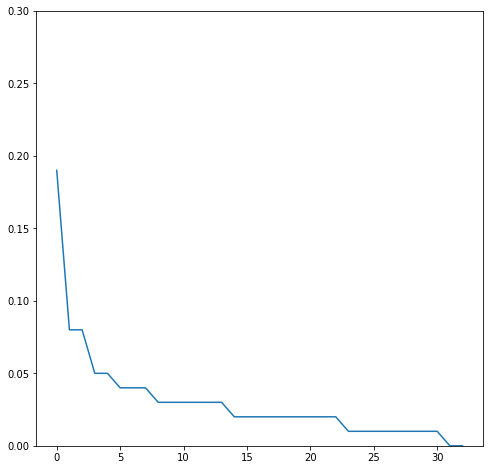

In [19]:
plt.figure(figsize=(8, 8))
plt.plot(pca.explained_variance_ratio_.round(2))
plt.ylim(0, 0.3)
plt.show()

In [20]:
X_train_pca = np.concatenate((X_train[:,:401], pca.transform(X_train[:,401:])), axis=1)
X_train_pca.shape

(2696, 434)

In [21]:
X_test_pca = np.concatenate((X_test[:,:401], pca.transform(X_test[:,401:])), axis=1)
X_test_pca.shape

(948, 434)

In [22]:
X_pca = np.concatenate((X[:,:401], pca.transform(X[:,401:])), axis=1)
X_pca.shape

(3644, 434)

## Selecting features

### Linear kernel

In [65]:
linear_estimator = SVR(kernel='linear', epsilon=1.94, C=0.009)
linear_selector = RFECV(linear_estimator, step=1,
                 scoring='neg_mean_squared_error',
                 cv=ps, n_jobs=1, verbose=1)
linear_selector.fit(
#     X,
    X_pca,
    y.ravel()
)

Fitting estimator with 434 features.
Fitting estimator with 433 features.
Fitting estimator with 432 features.
Fitting estimator with 431 features.
Fitting estimator with 430 features.
Fitting estimator with 429 features.
Fitting estimator with 428 features.
Fitting estimator with 427 features.
Fitting estimator with 426 features.
Fitting estimator with 425 features.
Fitting estimator with 424 features.
Fitting estimator with 423 features.
Fitting estimator with 422 features.
Fitting estimator with 421 features.
Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
F

Fitting estimator with 212 features.
Fitting estimator with 211 features.
Fitting estimator with 210 features.
Fitting estimator with 209 features.
Fitting estimator with 208 features.
Fitting estimator with 207 features.
Fitting estimator with 206 features.
Fitting estimator with 205 features.
Fitting estimator with 204 features.
Fitting estimator with 203 features.
Fitting estimator with 202 features.
Fitting estimator with 201 features.
Fitting estimator with 200 features.
Fitting estimator with 199 features.
Fitting estimator with 198 features.
Fitting estimator with 197 features.
Fitting estimator with 196 features.
Fitting estimator with 195 features.
Fitting estimator with 194 features.
Fitting estimator with 193 features.
Fitting estimator with 192 features.
Fitting estimator with 191 features.
Fitting estimator with 190 features.
Fitting estimator with 189 features.
Fitting estimator with 188 features.
Fitting estimator with 187 features.
Fitting estimator with 186 features.
F

Fitting estimator with 420 features.
Fitting estimator with 419 features.
Fitting estimator with 418 features.
Fitting estimator with 417 features.
Fitting estimator with 416 features.
Fitting estimator with 415 features.
Fitting estimator with 414 features.
Fitting estimator with 413 features.
Fitting estimator with 412 features.
Fitting estimator with 411 features.
Fitting estimator with 410 features.
Fitting estimator with 409 features.
Fitting estimator with 408 features.
Fitting estimator with 407 features.
Fitting estimator with 406 features.
Fitting estimator with 405 features.
Fitting estimator with 404 features.
Fitting estimator with 403 features.
Fitting estimator with 402 features.
Fitting estimator with 401 features.
Fitting estimator with 400 features.
Fitting estimator with 399 features.
Fitting estimator with 398 features.
Fitting estimator with 397 features.
Fitting estimator with 396 features.
Fitting estimator with 395 features.
Fitting estimator with 394 features.
F

RFECV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
      estimator=SVR(C=0.009, cache_size=200, coef0=0.0, degree=3, epsilon=1.94,
                    gamma='auto_deprecated', kernel='linear', max_iter=-1,
                    shrinking=True, tol=0.001, verbose=False),
      min_features_to_select=1, n_jobs=1, scoring='neg_mean_squared_error',
      step=1, verbose=1)

In [66]:
sum(linear_selector.support_)

269

In [67]:
# X_sel = X[:,linear_selector.support_]
# X_train_sel = X_train[:,linear_selector.support_]
# X_test_sel = X_test[:,linear_selector.support_]

X_sel = X_pca[:,linear_selector.support_]
X_train_sel = X_train_pca[:,linear_selector.support_]
X_test_sel = X_test_pca[:,linear_selector.support_]

## Tuning model

### GP tuner

#### Linear kernel regression

In [77]:
linear_space  = [
    Real(1, 3, 'uniform', name='epsilon'),
    Real(0.005, 0.03, 'uniform', name='C'),
]

In [78]:
linear_gp_model = SVR(kernel='linear')

@use_named_args(linear_space)
def linear_objective(**params):
    linear_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            linear_gp_model,
#             X,
#             X_pca,
            X_sel,
            y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [79]:
linear_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    linear_res_gp = gp_minimize(linear_objective, linear_space, n_calls=200, verbose=2)
    linear_res_gp_arr.append(linear_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 1.3114
Function value obtained: 9.5914
Current minimum: 9.5914
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 1.5687
Function value obtained: 9.5413
Current minimum: 9.5413
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.8960
Function value obtained: 9.9295
Current minimum: 9.5413
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.6802
Function value obtained: 9.5820
Current minimum: 9.5413
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 1.9631
Function value obtained: 10.0353
Current minimum: 9.5413
Iteration

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 2.4027
Function value obtained: 9.4911
Current minimum: 9.4888
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 2.4259
Function value obtained: 9.4912
Current minimum: 9.4888
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 2.5908
Function value obtained: 9.4911
Current minimum: 9.4888
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 2.4026
Function value obtained: 9.4911
Current minimum: 9.4888
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 2.4553
Function value obtained: 9.4910
Current minimum: 9.4888
Iteration No: 46 started. Sea

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 3.0173
Function value obtained: 9.4879
Current minimum: 9.4874
Iteration No: 82 started. Searching for the next optimal point.
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 2.9867
Function value obtained: 9.4889
Current minimum: 9.4874
Iteration No: 83 started. Searching for the next optimal point.
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 2.9850
Function value obtained: 9.4893
Current minimum: 9.4874
Iteration No: 84 started. Searching for the next optimal point.
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 3.0694
Function value obtained: 9.4895
Current minimum: 9.4874
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 3.0568
Function value obtained: 9.4896
Current minimum: 9.4874
Iteration No: 86 started. Sea

Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 4.0960
Function value obtained: 9.4892
Current minimum: 9.4874
Iteration No: 122 started. Searching for the next optimal point.
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 4.0315
Function value obtained: 9.4892
Current minimum: 9.4874
Iteration No: 123 started. Searching for the next optimal point.
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 4.3646
Function value obtained: 9.4893
Current minimum: 9.4874
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 3.9973
Function value obtained: 9.4893
Current minimum: 9.4874
Iteration No: 125 started. Searching for the next optimal point.
Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 4.2775
Function value obtained: 9.4893
Current minimum: 9.4874
Iteration No: 126 st

Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 5.2988
Function value obtained: 9.4895
Current minimum: 9.4874
Iteration No: 162 started. Searching for the next optimal point.
Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 5.3005
Function value obtained: 9.4895
Current minimum: 9.4874
Iteration No: 163 started. Searching for the next optimal point.
Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 5.5042
Function value obtained: 9.4895
Current minimum: 9.4874
Iteration No: 164 started. Searching for the next optimal point.
Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 5.3580
Function value obtained: 9.4906
Current minimum: 9.4874
Iteration No: 165 started. Searching for the next optimal point.
Iteration No: 165 ended. Search finished for the next optimal point.
Time taken: 5.4131
Function value obtained: 9.4898
Current minimum: 9.4874
Iteration No: 166 st

In [80]:
# Selected PCA (with elements)
for i in linear_res_gp_arr:
    print(i.fun)
print('\n')
for i in linear_res_gp_arr:
    print(i.x)

9.487424393564483


[1.9342373044134793, 0.01171574141196055]


In [34]:
# Full PCA (with elements)
for i in linear_res_gp_arr:
    print(i.fun)
print('\n')
for i in linear_res_gp_arr:
    print(i.x)

9.504610683290739


[1.9445943631656093, 0.009228107684449486]


In [54]:
# Full features (with elements)
for i in linear_res_gp_arr:
    print(i.fun)
print('\n')
for i in linear_res_gp_arr:
    print(i.x)

9.508804983454286


[1.9517947925053325, 0.011061175539736231]


In [61]:
# Selected features (with elements)
for i in linear_res_gp_arr:
    print(i.fun)
print('\n')
for i in linear_res_gp_arr:
    print(i.x)

9.494869643547798


[1.93636130880968, 0.009944082816547729]


#### RBF kernel regression

In [30]:
rbf_space  = [
    Real(1, 3, 'uniform', name='epsilon'),
    Real(0.1, 2, 'uniform', name='C'),
    Real(0.01, 0.03,  'uniform', name='gamma'),
]

In [74]:
rbf_gp_model = SVR(kernel='rbf')

@use_named_args(rbf_space)
def rbf_objective(**params):
    rbf_gp_model.set_params(**params)

    return -np.mean(
        cross_val_score(
            rbf_gp_model,
#             X,
#             X_pca,
            X_sel,
            y.ravel(),
            cv=ps,
            n_jobs=1,
            scoring="neg_mean_squared_error"))

In [75]:
rbf_res_gp_arr = []
for i in range(1, 2):
    print('minimisation iteration', i)
    rbf_res_gp = gp_minimize(rbf_objective, rbf_space, n_calls=200, verbose=2)
    rbf_res_gp_arr.append(rbf_res_gp)

minimisation iteration 1
Iteration No: 1 started. Evaluating function at random point.
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 3.3163
Function value obtained: 10.9608
Current minimum: 10.9608
Iteration No: 2 started. Evaluating function at random point.
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 2.0754
Function value obtained: 9.9892
Current minimum: 9.9892
Iteration No: 3 started. Evaluating function at random point.
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 1.0434
Function value obtained: 9.8706
Current minimum: 9.8706
Iteration No: 4 started. Evaluating function at random point.
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 1.4452
Function value obtained: 10.4028
Current minimum: 9.8706
Iteration No: 5 started. Evaluating function at random point.
Iteration No: 5 ended. Evaluation done at random point.
Time taken: 2.9440
Function value obtained: 11.1897
Current minimum: 9.8706
Iterat

Iteration No: 41 ended. Search finished for the next optimal point.
Time taken: 2.7183
Function value obtained: 9.5655
Current minimum: 9.4860
Iteration No: 42 started. Searching for the next optimal point.
Iteration No: 42 ended. Search finished for the next optimal point.
Time taken: 2.6084
Function value obtained: 9.5021
Current minimum: 9.4860
Iteration No: 43 started. Searching for the next optimal point.
Iteration No: 43 ended. Search finished for the next optimal point.
Time taken: 2.5751
Function value obtained: 9.6153
Current minimum: 9.4860
Iteration No: 44 started. Searching for the next optimal point.
Iteration No: 44 ended. Search finished for the next optimal point.
Time taken: 1.3752
Function value obtained: 15.0992
Current minimum: 9.4860
Iteration No: 45 started. Searching for the next optimal point.
Iteration No: 45 ended. Search finished for the next optimal point.
Time taken: 2.5187
Function value obtained: 9.4974
Current minimum: 9.4860
Iteration No: 46 started. Se

Iteration No: 81 ended. Search finished for the next optimal point.
Time taken: 3.6039
Function value obtained: 9.7512
Current minimum: 9.4675
Iteration No: 82 started. Searching for the next optimal point.
Iteration No: 82 ended. Search finished for the next optimal point.
Time taken: 3.5317
Function value obtained: 9.5004
Current minimum: 9.4675
Iteration No: 83 started. Searching for the next optimal point.
Iteration No: 83 ended. Search finished for the next optimal point.
Time taken: 5.4575
Function value obtained: 10.8199
Current minimum: 9.4675
Iteration No: 84 started. Searching for the next optimal point.
Iteration No: 84 ended. Search finished for the next optimal point.
Time taken: 3.3278
Function value obtained: 9.5648
Current minimum: 9.4675
Iteration No: 85 started. Searching for the next optimal point.
Iteration No: 85 ended. Search finished for the next optimal point.
Time taken: 3.7208
Function value obtained: 9.5573
Current minimum: 9.4675
Iteration No: 86 started. Se

Iteration No: 121 ended. Search finished for the next optimal point.
Time taken: 6.1998
Function value obtained: 9.7891
Current minimum: 9.4630
Iteration No: 122 started. Searching for the next optimal point.
Iteration No: 122 ended. Search finished for the next optimal point.
Time taken: 7.4018
Function value obtained: 10.3667
Current minimum: 9.4630
Iteration No: 123 started. Searching for the next optimal point.
Iteration No: 123 ended. Search finished for the next optimal point.
Time taken: 4.5529
Function value obtained: 9.4841
Current minimum: 9.4630
Iteration No: 124 started. Searching for the next optimal point.
Iteration No: 124 ended. Search finished for the next optimal point.
Time taken: 4.6946
Function value obtained: 9.5234
Current minimum: 9.4630
Iteration No: 125 started. Searching for the next optimal point.
Iteration No: 125 ended. Search finished for the next optimal point.
Time taken: 4.7939
Function value obtained: 9.4963
Current minimum: 9.4630
Iteration No: 126 s

Iteration No: 161 ended. Search finished for the next optimal point.
Time taken: 5.8842
Function value obtained: 9.4652
Current minimum: 9.4630
Iteration No: 162 started. Searching for the next optimal point.
Iteration No: 162 ended. Search finished for the next optimal point.
Time taken: 5.9676
Function value obtained: 9.4653
Current minimum: 9.4630
Iteration No: 163 started. Searching for the next optimal point.
Iteration No: 163 ended. Search finished for the next optimal point.
Time taken: 5.8640
Function value obtained: 9.4646
Current minimum: 9.4630
Iteration No: 164 started. Searching for the next optimal point.
Iteration No: 164 ended. Search finished for the next optimal point.
Time taken: 5.7550
Function value obtained: 9.4653
Current minimum: 9.4630
Iteration No: 165 started. Searching for the next optimal point.
Iteration No: 165 ended. Search finished for the next optimal point.
Time taken: 5.8605
Function value obtained: 9.4644
Current minimum: 9.4630
Iteration No: 166 st

In [76]:
# Selected PCA (with elements)
for i in rbf_res_gp_arr:
    print(i.fun)
print('\n')
for i in rbf_res_gp_arr:
    print(i.x)

9.462986924415606


[2.083622187058813, 1.1286669441713073, 0.01650219986973197]


In [44]:
# Full PCA (with elements)
for i in rbf_res_gp_arr:
    print(i.fun)
print('\n')
for i in rbf_res_gp_arr:
    print(i.x)

9.485421989660821


[1.9815766643176866, 2.0252813343301512, 0.00367659358750877]


In [33]:
# Full features (with elements)
for i in rbf_res_gp_arr:
    print(i.fun)
print('\n')
for i in rbf_res_gp_arr:
    print(i.x)

9.492622766557847


[2.0043406553750764, 2.433059473305185, 0.004186662041573401]


In [64]:
# Selected features (with elements)
for i in rbf_res_gp_arr:
    print(i.fun)
print('\n')
for i in rbf_res_gp_arr:
    print(i.x)

9.478263817314705


[2.032050918923715, 1.52188440327102, 0.0063867018528761645]


### Grid search

#### Linear kernel regression

In [103]:
linear_epsilon = [1.92, 1.93, 1.94]
linear_C = [0.0116, 0.0117, 0.0118]

linear_parameters = {
    'C': linear_C,
    'epsilon': linear_epsilon
}

In [104]:
gs_model_linear = GridSearchCV(
    SVR(kernel='linear'),
    linear_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=1)
gs_model_linear.fit(X_sel, y.ravel())

Fitting 1 folds for each of 9 candidates, totalling 9 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done   9 out of   9 | elapsed:   18.2s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated',
                           kernel='linear', max_iter=-1, shrinking=True,
                           tol=0.001, verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'C': [0.0116, 0.0117, 0.0118],
                         'epsilon': [1.92, 1.93, 1.94]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
             verbose=1)

In [105]:
gs_model_linear_df = pd.DataFrame(gs_model_linear.cv_results_)[[
    'param_C','param_epsilon',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_linear_df

,param_C,param_epsilon,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,0.0116,1.92,-2.192115,-9.493836
1,0.0116,1.93,-2.193911,-9.489001
2,0.0116,1.94,-2.195861,-9.489670
3,0.0117,1.92,-2.192101,-9.493505
4,0.0117,1.93,-2.193884,-9.488852
5,0.0117,1.94,-2.195930,-9.489770
6,0.0118,1.92,-2.192080,-9.493126
7,0.0118,1.93,-2.193921,-9.488831
8,0.0118,1.94,-2.195932,-9.489544


In [106]:
gs_model_linear_df[
    gs_model_linear_df['split0_test_neg_mean_squared_error'] == \
    gs_model_linear_df['split0_test_neg_mean_squared_error'].max()]

,param_C,param_epsilon,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
7,0.0118,1.93,-2.193921,-9.488831


#### RBF kernel regression

In [107]:
rbf_epsilon = [2.07, 2.08, 2.09]
rbf_C = [1.12, 1.13, 1.14]
rbf_gamma = [0.0164, 0.0165, 0.0166]

rbf_parameters = {
    'C': rbf_C,
    'epsilon': rbf_epsilon,
    'gamma': rbf_gamma
}

In [108]:
gs_model_rbf = GridSearchCV(
    SVR(kernel='rbf'),
    rbf_parameters,
    scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
    refit=False,
    cv=ps,
    error_score=100, n_jobs=1, verbose=1)
gs_model_rbf.fit(X_sel, y.ravel())

Fitting 1 folds for each of 27 candidates, totalling 27 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  27 out of  27 | elapsed:   57.1s finished


GridSearchCV(cv=PredefinedSplit(test_fold=array([-1, -1, ...,  0,  0])),
             error_score=100,
             estimator=SVR(C=1.0, cache_size=200, coef0=0.0, degree=3,
                           epsilon=0.1, gamma='auto_deprecated', kernel='rbf',
                           max_iter=-1, shrinking=True, tol=0.001,
                           verbose=False),
             iid='warn', n_jobs=1,
             param_grid={'C': [1.12, 1.13, 1.14], 'epsilon': [2.07, 2.08, 2.09],
                         'gamma': [0.0164, 0.0165, 0.0166]},
             pre_dispatch='2*n_jobs', refit=False, return_train_score=False,
             scoring=['neg_mean_absolute_error', 'neg_mean_squared_error'],
             verbose=1)

In [109]:
gs_model_rbf_df = pd.DataFrame(gs_model_rbf.cv_results_)[[
    'param_C','param_epsilon', 'param_gamma',
    'split0_test_neg_mean_absolute_error',
    'split0_test_neg_mean_squared_error'
]]

gs_model_rbf_df

,param_C,param_epsilon,param_gamma,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
0,1.12,2.07,0.0164,-2.253828,-9.463162
1,1.12,2.07,0.0165,-2.253945,-9.463113
2,1.12,2.07,0.0166,-2.254050,-9.463136
3,1.12,2.08,0.0164,-2.255693,-9.462789
4,1.12,2.08,0.0165,-2.255843,-9.462950
5,1.12,2.08,0.0166,-2.255921,-9.463006
6,1.12,2.09,0.0164,-2.257686,-9.463292
7,1.12,2.09,0.0165,-2.257853,-9.463480
8,1.12,2.09,0.0166,-2.257978,-9.463501
9,1.13,2.07,0.0164,-2.253988,-9.462996


In [110]:
gs_model_rbf_df[
    gs_model_rbf_df['split0_test_neg_mean_squared_error'] == \
    gs_model_rbf_df['split0_test_neg_mean_squared_error'].max()]

,param_C,param_epsilon,param_gamma,split0_test_neg_mean_absolute_error,split0_test_neg_mean_squared_error
21,1.14,2.08,0.0164,-2.256037,-9.462756


# Evaluating model

## Linear kernel

### PC with feature selection

In [83]:
linear_model = SVR(kernel='linear', epsilon=1.93, C=0.0117)
linear_model.fit(X_train_sel, y_train.ravel())

SVR(C=0.0117, cache_size=200, coef0=0.0, degree=3, epsilon=1.93,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [84]:
# get predictions for test set
linear_y_pred = linear_model.predict(X_test_sel).flatten()

# calculate cross entropy loss for test set
linear_test_loss = (
    mean_absolute_error(y_test, linear_y_pred),
    mean_squared_error(y_test, linear_y_pred),
    r2_score(y_test, linear_y_pred)
)
linear_test_loss

(2.1938838252493147, 9.488851816313849, 0.08820844796443605)

In [85]:
# refit linear_model on all data
linear_model_full = SVR(kernel='linear', epsilon=1.93, C=0.0117)
linear_model_full.fit(X_sel, y.ravel())

SVR(C=0.0117, cache_size=200, coef0=0.0, degree=3, epsilon=1.93,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [86]:
# get predictions for whole set
linear_y_pred_full = linear_model_full.predict(X_sel).flatten()

# calculate cross entropy loss for test set
linear_test_loss_full = (
    mean_absolute_error(y, linear_y_pred_full),
    mean_squared_error(y, linear_y_pred_full),
    r2_score(y, linear_y_pred_full)
)
linear_test_loss_full

(2.123706722743322, 8.523414477043204, 0.10922677648596801)

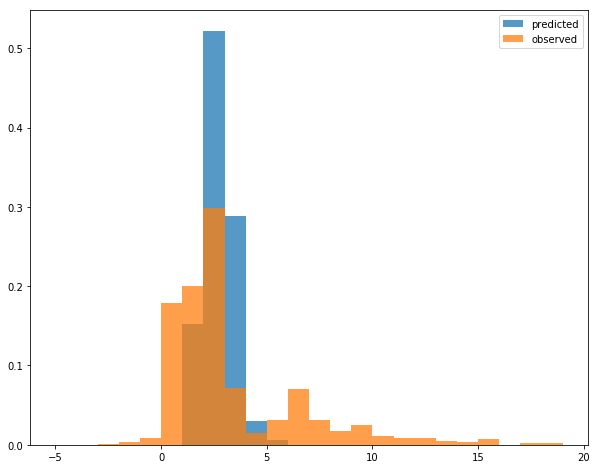

In [87]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(linear_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

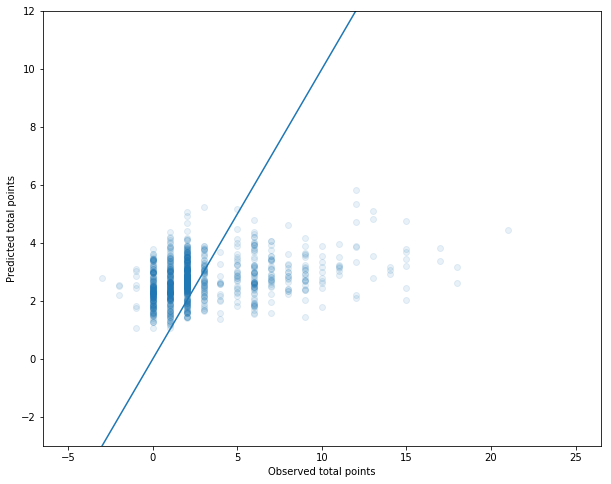

In [88]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(linear_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### All features

In [89]:
linear_model_all = SVR(kernel='linear', epsilon=1.95, C=0.0111)
linear_model_all.fit(X_train, y_train.ravel())

SVR(C=0.0111, cache_size=200, coef0=0.0, degree=3, epsilon=1.95,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [90]:
# get predictions for test set
linear_y_pred_all = linear_model_all.predict(X_test).flatten()

# calculate cross entropy loss for test set
linear_test_loss_all = (
    mean_absolute_error(y_test, linear_y_pred_all),
    mean_squared_error(y_test, linear_y_pred_all),
    r2_score(y_test, linear_y_pred_all)
)
linear_test_loss_all

(2.2044522880983513, 9.50839872730995, 0.08633016925804982)

In [91]:
# refit linear_model on all data
linear_model_full_all = SVR(kernel='linear', epsilon=1.95, C=0.0111)
linear_model_full_all.fit(X, y.ravel())

SVR(C=0.0111, cache_size=200, coef0=0.0, degree=3, epsilon=1.95,
    gamma='auto_deprecated', kernel='linear', max_iter=-1, shrinking=True,
    tol=0.001, verbose=False)

In [92]:
# get predictions for whole set
linear_y_pred_full_all = linear_model_full_all.predict(X).flatten()

# calculate cross entropy loss for test set
linear_test_loss_full_all = (
    mean_absolute_error(y, linear_y_pred_full_all),
    mean_squared_error(y, linear_y_pred_full_all),
    r2_score(y, linear_y_pred_full_all)
)
linear_test_loss_full_all

(2.1296003985805667, 8.528213349110882, 0.10872525133399169)

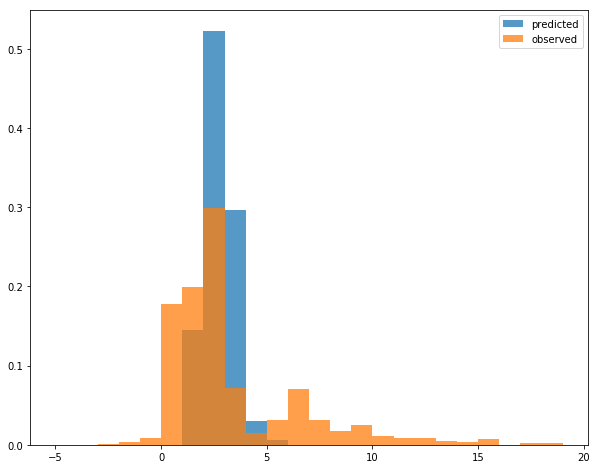

In [93]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(linear_y_pred_all), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

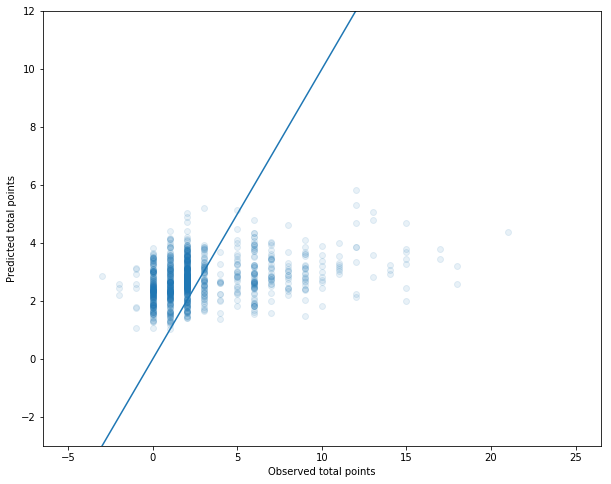

In [94]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(linear_y_pred_all), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## RBF kernel

### PC with feature selection

In [117]:
rbf_model = SVR(kernel='rbf', epsilon=2.08, C=1.14, gamma=0.0164)
rbf_model.fit(X_train_sel, y_train.ravel())

SVR(C=1.14, cache_size=200, coef0=0.0, degree=3, epsilon=2.08, gamma=0.0164,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [118]:
# get predictions for test set
rbf_y_pred = rbf_model.predict(X_test_sel).flatten()

# calculate cross entropy loss for test set
rbf_test_loss = (
    mean_absolute_error(y_test, rbf_y_pred),
    mean_squared_error(y_test, rbf_y_pred),
    r2_score(y_test, rbf_y_pred)
)
rbf_test_loss

(2.2560366447915245, 9.46275615809887, 0.09071600116115863)

In [119]:
# refit rbf_model on all data
rbf_model_full = SVR(kernel='rbf', epsilon=2.08, C=1.14, gamma=0.0164)
rbf_model_full.fit(X_sel, y.ravel())

SVR(C=1.14, cache_size=200, coef0=0.0, degree=3, epsilon=2.08, gamma=0.0164,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [120]:
# get predictions for whole set
rbf_y_pred_full = rbf_model_full.predict(X_sel).flatten()

# calculate cross entropy loss for test set
rbf_test_loss_full = (
    mean_absolute_error(y, rbf_y_pred_full),
    mean_squared_error(y, rbf_y_pred_full),
    r2_score(y, rbf_y_pred_full)
)
rbf_test_loss_full

(2.129405870788312, 8.048882021517402, 0.15881967217457293)

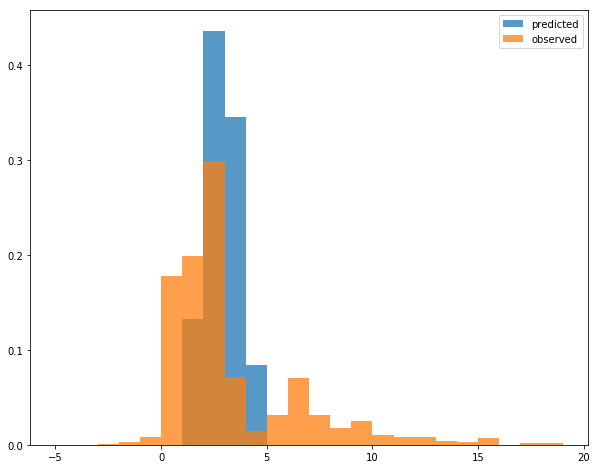

In [121]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(rbf_y_pred), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

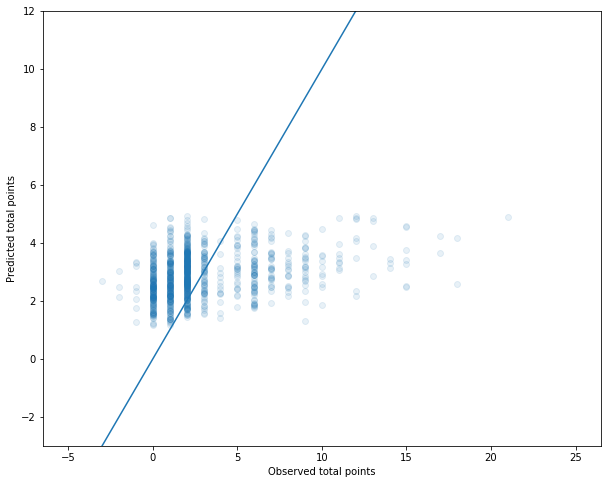

In [122]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(rbf_y_pred), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

### All features

In [123]:
rbf_model_all = SVR(kernel='rbf', epsilon=2.00, C=2.43, gamma=0.00419)
rbf_model_all.fit(X_train, y_train.ravel())

SVR(C=2.43, cache_size=200, coef0=0.0, degree=3, epsilon=2.0, gamma=0.00419,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [124]:
# get predictions for test set
rbf_y_pred_all = rbf_model_all.predict(X_test).flatten()

# calculate cross entropy loss for test set
rbf_test_loss_all = (
    mean_absolute_error(y_test, rbf_y_pred_all),
    mean_squared_error(y_test, rbf_y_pred_all),
    r2_score(y_test, rbf_y_pred_all)
)
rbf_test_loss_all

(2.22585136873826, 9.492514876436255, 0.08785646151350768)

In [125]:
# refit rbf_model on all data
rbf_model_full_all = SVR(kernel='rbf', epsilon=2.00, C=2.43, gamma=0.00419)
rbf_model_full_all.fit(X, y.ravel())

SVR(C=2.43, cache_size=200, coef0=0.0, degree=3, epsilon=2.0, gamma=0.00419,
    kernel='rbf', max_iter=-1, shrinking=True, tol=0.001, verbose=False)

In [126]:
# get predictions for whole set
rbf_y_pred_full_all = rbf_model_full_all.predict(X).flatten()

# calculate cross entropy loss for test set
rbf_test_loss_full_all = (
    mean_absolute_error(y, rbf_y_pred_full_all),
    mean_squared_error(y, rbf_y_pred_full_all),
    r2_score(y, rbf_y_pred_full_all)
)
rbf_test_loss_full_all

(2.1236381183400153, 8.29164477447774, 0.13344878817191697)

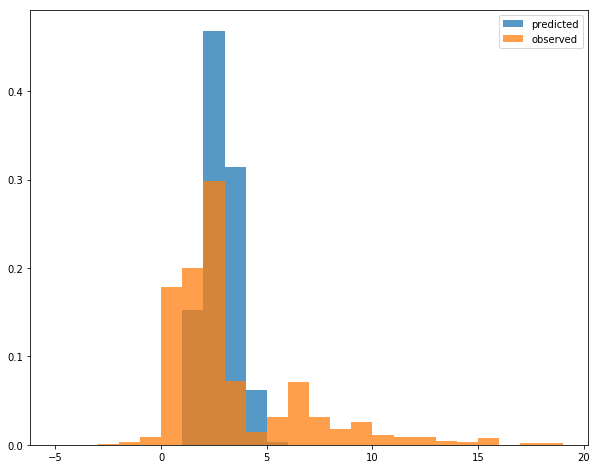

In [127]:
plt.figure(figsize=(10, 8))
plt.hist(pd.Series(rbf_y_pred_all), bins=range(-5,20), alpha=0.75, density=True, label='predicted')
plt.hist(pd.Series(y_test.ravel()), bins=range(-5,20), alpha=0.75, density=True, label='observed')
plt.legend()
plt.show()

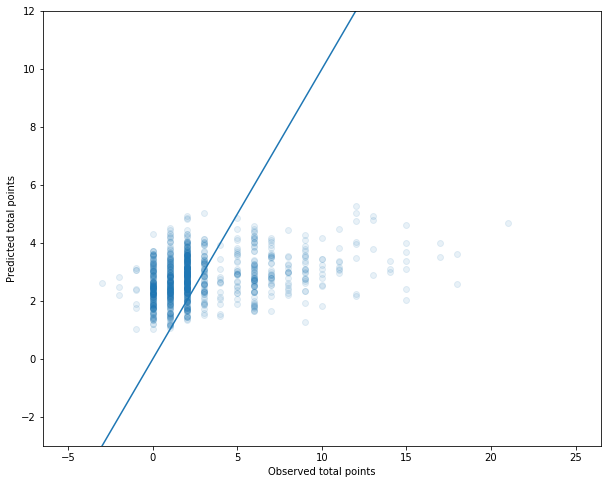

In [128]:
plt.figure(figsize=(10, 8))
plt.scatter(pd.Series(y_test.ravel()), pd.Series(rbf_y_pred_all), alpha=0.1)
plt.plot(np.linspace(-5, 25), np.linspace(-5, 25))
plt.ylabel('Predicted total points')
plt.xlabel('Observed total points')
plt.ylim((-3, 12))
plt.show()

## Summary

In [129]:
pd.DataFrame([
    ('Linear kernel (selected PC)', linear_test_loss[0], linear_test_loss[1], linear_test_loss[2]),
    ('Linear kernel (all)', linear_test_loss_all[0], linear_test_loss_all[1], linear_test_loss_all[2]),
    ('RBF kernel (selected PC)', rbf_test_loss[0], rbf_test_loss[1], rbf_test_loss[2]),
    ('RBF kernel (all)', rbf_test_loss_all[0], rbf_test_loss_all[1], rbf_test_loss_all[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Linear kernel (selected PC),2.193884,9.488852,0.088208
1,Linear kernel (all),2.204452,9.508399,0.086330
2,RBF kernel (selected PC),2.256037,9.462756,0.090716
3,RBF kernel (all),2.225851,9.492515,0.087856


In [130]:
pd.DataFrame([
    ('Linear kernel (selected PC)', linear_test_loss_full[0], linear_test_loss_full[1], linear_test_loss_full[2]),
    ('Linear kernel (all)', linear_test_loss_full_all[0], linear_test_loss_full_all[1], linear_test_loss_full_all[2]),
    ('RBF kernel (selected PC)', rbf_test_loss_full[0], rbf_test_loss_full[1], rbf_test_loss_full[2]),
    ('RBF kernel (all)', rbf_test_loss_full_all[0], rbf_test_loss_full_all[1], rbf_test_loss_full_all[2]),
], columns=['model', 'MAE', 'MSE', 'r2'])

,model,MAE,MSE,r2
0,Linear kernel (selected PC),2.123707,8.523414,0.109227
1,Linear kernel (all),2.129600,8.528213,0.108725
2,RBF kernel (selected PC),2.129406,8.048882,0.158820
3,RBF kernel (all),2.123638,8.291645,0.133449


*Linear kernel*
 - modest improvement with PCA
 - modest improvement with RFE
 - best results for PCA with RFE

*RBF kernel*
 - modest improvement with PCA
 - modest improvement with RFE
 - best results for PCA with RFE